Importing the necessaries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.ensemble import IsolationForest
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
import torch

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the dataset from disk

In [2]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Inspecting data

In [3]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,mai taci,1,0,0,0,0
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0
3,el e in high elo,1,0,0,0,0
4,ai vol iu,1,0,0,0,0


In [4]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,giorgii,1,0,0,0,0
1,atata timp cat nu dau tag la euneeuw pur si s...,1,0,0,0,0
2,duoq,1,0,0,0,0
3,Ar trebui sa il stii atunci,1,0,0,0,0
4,nu e din ala,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [5]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,21282.000000,21282.000000,21282.000000,21282.000000,21282.000000
mean,0.524011,0.383517,0.101447,0.179400,0.115027
std,0.499435,0.486254,0.301927,0.383696,0.319062
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,5315.000000,5315.000000,5315.000000,5315.000000,5315.000000
mean,0.524365,0.385701,0.110442,0.173283,0.116651
std,0.499453,0.486806,0.313470,0.378527,0.321034
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21282 entries, 0 to 21281
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   21282 non-null  object
 1   OK        21282 non-null  int64 
 2   Aggro     21282 non-null  int64 
 3   Violence  21282 non-null  int64 
 4   Sexual    21282 non-null  int64 
 5   Hateful   21282 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 997.7+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   5315 non-null   object
 1   OK        5315 non-null   int64 
 2   Aggro     5315 non-null   int64 
 3   Violence  5315 non-null   int64 
 4   Sexual    5315 non-null   int64 
 5   Hateful   5315 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 249.3+ KB


In [9]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [10]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (21282, 6)
Test shape:  (5315, 6)


In [11]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 2629
Number of duplicated instances in test: 582


In [12]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.826406 -0.308922 -0.449884 -0.359106
Aggro    -0.826406  1.000000  0.165151  0.303171  0.264460
Violence -0.308922  0.165151  1.000000  0.065984  0.109585
Sexual   -0.449884  0.303171  0.065984  1.000000  0.059428
Hateful  -0.359106  0.264460  0.109585  0.059428  1.000000


Data visualization

In [13]:
import matplotlib.pyplot as plt # importing the neccessary library

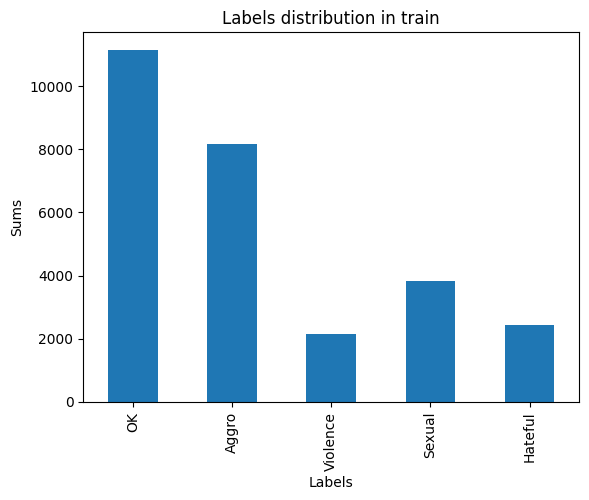

OK          11152
Aggro        8162
Violence     2159
Sexual       3818
Hateful      2448
dtype: int64


In [14]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

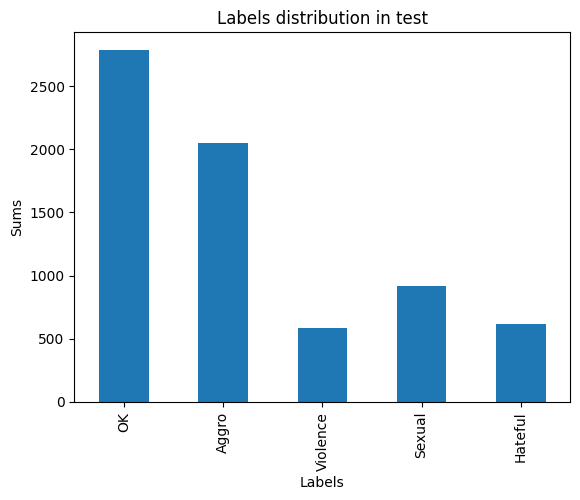

OK          2787
Aggro       2050
Violence     587
Sexual       921
Hateful      620
dtype: int64


In [15]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

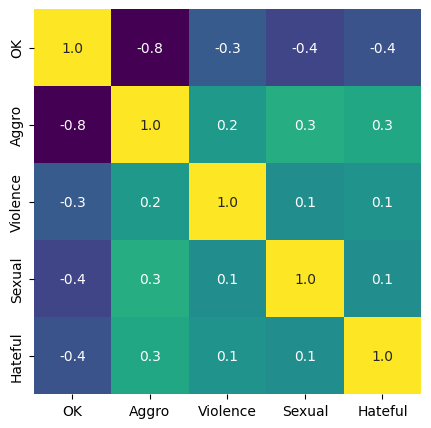

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

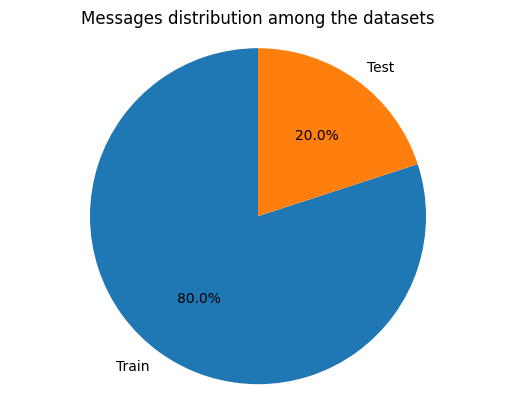

[np.int64(21282), np.int64(5315)]


In [17]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [18]:
accuracy_array = []
models_used = ['opjlm']

### My model

In [19]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [20]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.5)] = 1
        return predictions

In [21]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v4', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [22]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/v4')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

In [23]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [24]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

In [25]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)
clsr = classification_report(y_test, y_pred, target_names=["OK","Aggro","Violence","Sexual","Hateful"])

print(clsr)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

          OK       0.94      0.92      0.93      2787
       Aggro       0.91      0.93      0.92      2050
    Violence       0.84      0.86      0.85       587
      Sexual       0.93      0.92      0.92       921
     Hateful       0.86      0.93      0.89       620

   micro avg       0.91      0.92      0.92      6965
   macro avg       0.90      0.91      0.90      6965
weighted avg       0.92      0.92      0.92      6965
 samples avg       0.91      0.91      0.91      6965

F1 Score: 0.9160874238624149
Precision: 0.9144492131616595
Recall: 0.9177315147164393
Accuracy: 0.8602069614299154
ROC AUC: 0.937151290352151


c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[2357,  171],
        [ 218, 2569]],

       [[3087,  178],
        [ 147, 1903]],

       [[4632,   96],
        [  85,  502]],

       [[4332,   62],
        [  77,  844]],

       [[4604,   91],
        [  46,  574]]])

### version 4 - large

In [27]:
dm_tokenizer = AutoTokenizer.from_pretrained("./model_versions/v4-large")

loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(dm_tokenizer)

X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

dm_model = ToxicityModel(
    model_name='./model_versions/v4-large', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )
models_used.append("v4-large")

y_pred = [dm_model.predict(text, dm_tokenizer) for text in X_test]

In [28]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)
clsr = classification_report(y_test, y_pred, target_names=["OK","Aggro","Violence","Sexual","Hateful"])

print(clsr)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

          OK       0.95      0.93      0.94      2787
       Aggro       0.92      0.94      0.93      2050
    Violence       0.87      0.86      0.87       587
      Sexual       0.95      0.94      0.94       921
     Hateful       0.89      0.92      0.91       620

   micro avg       0.93      0.93      0.93      6965
   macro avg       0.92      0.92      0.92      6965
weighted avg       0.93      0.93      0.93      6965
 samples avg       0.92      0.92      0.92      6965

F1 Score: 0.9275341480948958
Precision: 0.928869690424766
Recall: 0.9262024407753051
Accuracy: 0.8805268109125117
ROC AUC: 0.9439848701891032


c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Setting Xs and ys

In [29]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(21282, 32525)


In [30]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(5315, 32525)

### Isolation Forest

In [31]:
clf =  IsolationForest(n_estimators=50, max_samples="auto", random_state=42, contamination=float(0.1))

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

clf.fit(X_train_2d)

IsolationForest(contamination=0.1, n_estimators=50, random_state=42)

In [32]:
df_train['scores'] = clf.decision_function(X_train_2d)
df_train['anomaly'] = clf.predict(X_train_2d)

df_train.head(20)

,Message,OK,Aggro,Violence,Sexual,Hateful,scores,anomaly
0,mai taci,1,0,0,0,0,0.083609,1
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0,0.072861,1
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0,0.092139,1
3,el e in high elo,1,0,0,0,0,0.115293,1
4,ai vol iu,1,0,0,0,0,0.124746,1
5,player exceptional,1,0,0,0,0,0.158065,1
6,a durat cv,1,0,0,0,0,0.161894,1
7,Same,1,0,0,0,0,0.148975,1
8,de unde stii ca i fata,1,0,0,0,0,0.094780,1
9,rateaz q ul ca tine,1,0,0,0,0,0.104847,1


In [33]:
anomaly = df_train.loc[df_train['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

                                                 Message  OK  Aggro  Violence  \
23                                                  n am   1      0         0   
37                     si nu mai merg la scoala de 2 ani   1      0         0   
47                                           ti am zis o   1      0         0   
61                                          nu l inchizi   1      0         0   
75                            Nu am jucat cu ei niciodat   1      0         0   
...                                                  ...  ..    ...       ...   
21208  dovada care arata foarte bine pe care trebuie ...   1      0         0   
21223  null lept pe jungla atat de mult voi spune ca ...   1      0         0   
21239  ei bine nu trebuie sa spuneti ca daca faceti o...   1      0         0   
21253          nu avertizati mai multe repetari da prost   1      0         0   
21281                             eu sau am intarziat ed   0      0         0   

       Sexual  Hateful    s

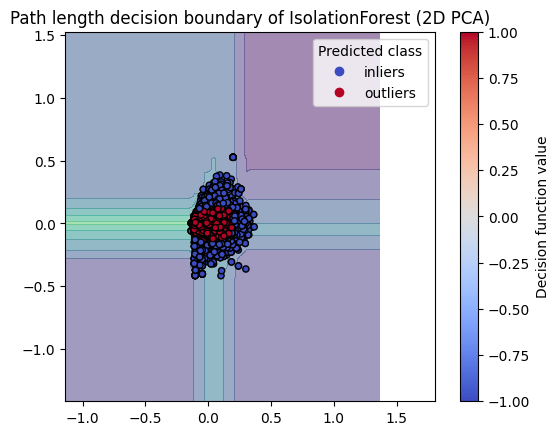

In [34]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_2d,
    response_method="decision_function",
    alpha=0.5,
)

y_pred = clf.predict(X_train_2d)  # -1 for outliers, 1 for inliers
scatter = disp.ax_.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")

disp.ax_.set_title("Path length decision boundary of IsolationForest (2D PCA)")
plt.axis("square")

# Legend for predicted classes
plt.legend(handles=scatter.legend_elements()[0], labels=["inliers", "outliers"], title="Predicted class")

# Add a color bar for the decision boundary
plt.colorbar(disp.ax_.collections[1], ax=disp.ax_, label="Decision function value")

plt.show()

df_train.drop(columns=['scores', 'anomaly'], inplace=True)

## Comparing accuracy between algorithms

<BarContainer object of 2 artists>

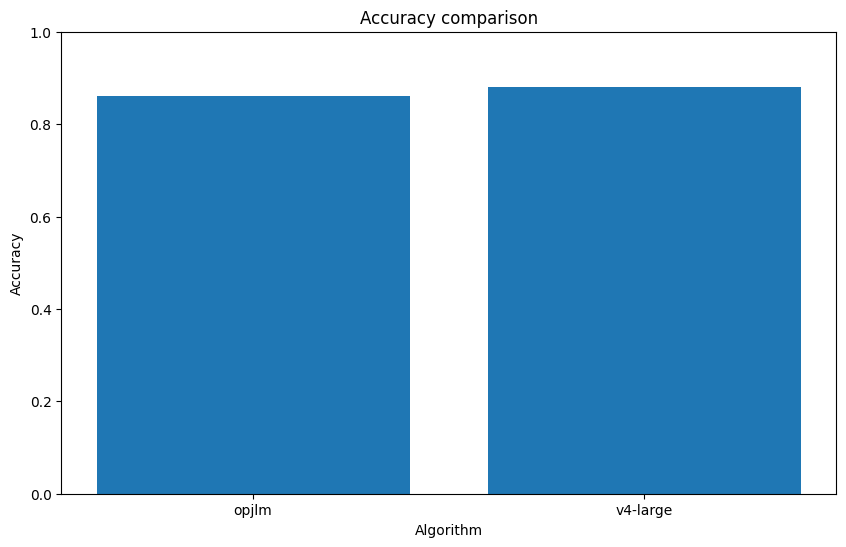

In [35]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, accuracy_array)

It takes over 8GB of RAM just to fit the model, run this cell when you don't need your computer for several minutes.

In [36]:
"""
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

model.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test.toarray())
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_array.append(accuracy)
models_used.append('GPR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_binary))
"""

"\nfrom sklearn.gaussian_process.kernels import DotProduct, WhiteKernel\nkernel = DotProduct() + WhiteKernel()\nmodel = GaussianProcessRegressor(kernel=kernel, random_state=42)\n\nmodel.fit(X_train.toarray(), y_train)\ny_pred = model.predict(X_test.toarray())\ny_pred_binary = (y_pred > 0.5).astype(int)\naccuracy = accuracy_score(y_test, y_pred_binary)\naccuracy_array.append(accuracy)\nmodels_used.append('GPR')\nprint(f'Accuracy: {accuracy:.2f}')\nprint(classification_report(y_test, y_pred_binary))\n"